# Non-Iterative Problems

Non-iterative problems converge to an optimum solution as opposed to iterative problems that don't have a definite end of tuning. Scikit-learn models generally fall under this. In this section we see how to work with these types of problems using the `Space` class we learned in the last section.

Have questions? Chat with us on Github or Slack:

[![Homepage](https://img.shields.io/badge/fugue-source--code-red?logo=github)](https://github.com/fugue-project/fugue)
[![Slack Status](https://img.shields.io/badge/slack-join_chat-white.svg?logo=slack&style=social)](http://slack.fugue.ai)

## Setup

We will use the California Housing dataset and train `scikit-learn` models on it. This code snippet will show how to load the data, but in practice it should be loaded in the objective function as seen below. This will make the code more scalable when running on a distributed backend like Spark or Dask. The cluster workers will be able to directly load the data rather than have it pass through the scheduler.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

# get training data
def get_data():
    return fetch_california_housing(as_frame=True).frame

get_data().head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Objective Function for Non-Iterative Problems

Tune requires that the objective function for non-iterative problems return either a `float` or `Tuple[float, Dict[str, Any]]`. The latter one is used to return both the metric and the metadata. It is required to have the type annotations so that Tune knows the structure of the objective function. For more involved objective functions where the properties of a trial are needed, users can use the `NonIterativeObjectiveFunc` class to define their objective function as seen later in the tutorials. This is just the preferred and most minimal approach to write out the objective function.

```python
def objective1(a, b) -> float:
    return a**2 + b**2

def objective2(a, b) -> Tuple[float, Dict[str, Any]]:
    return a**2 + b**2, {"metadata":"x"}
```


For this example, our objective function to take in a model and the accompanying hyperparameters for the model. We then return the `mean_absolute_percentage_error` across the folds of model training with cross validation.

In [67]:
from typing import Tuple, Dict, Any
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

def objective(model:Any, **hp:Any) -> float:
    model_ins = model(**hp)
    # load data inside objective
    data = get_data()
    y = data["MedHouseVal"]
    x = data.drop("MedHouseVal", axis=1)
    scores = cross_val_score(model_ins, x, y, cv=3, 
                             scoring=make_scorer(mean_absolute_percentage_error))
    return scores.mean()

We can test this objective function by passing in sample models already even without the Tune library. These will give us benchmark values.

In [3]:

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

print("XGB Baseline:", objective(XGBRegressor))
print("LGBM Baseline", objective(LGBMRegressor))

XGB Baseline: 0.28180971125916277
LGBM Baseline 0.26024866093016924


## Constructing the Search Space

In the previous section of the tutorial, we learned about the `Space` class and how to construct a search space. Below is an example how to use it for XGBoost and LightGBM. Recall that the `Space` is decoupled from any specific tuning framework.

In [66]:

from tune import Space, RandInt, Grid

xgb_space = Space(model=XGBRegressor, n_estimators=Grid(100, 200, 300))
lgbm_space = Space(model=LGBMRegressor, n_estimators=RandInt(100, 300))
list(xgb_space + lgbm_space)

[{'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100},
 {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 200},
 {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 300},
 {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': RandInt(low=100, high=300, q=1, log=False, include_high=True)}]

# Tuning Non-Iterative Objectives

Now we can use the `suggest_for_non_iterative_objective()` function to put the objective function and search space together. This function has a lot more functionality, this is just the basic use case. It will return the best result among the trials.

Because we have a parameter called `model` in the `Space`, this will be fed into the objective function `model` argument.

In [5]:
from tune import suggest_for_noniterative_objective

result = suggest_for_noniterative_objective(
    objective,
    xgb_space,
)
result

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


[{'trial': {'trial_id': 'fcfcdf23-1a9f-56a2-8638-6a32280d8ed0', 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100}, 'metadata': {}, 'keys': []}, 'metric': 0.28180971125916277, 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.28180971125916277, 'log_time': datetime.datetime(2022, 9, 1, 0, 49, 1, 587778)}]

The result contains the metrics and metadata of the best trial. 

## Tuning with an Optimizer

The example above only used the `xgb_space` because the `lgbm_space` has a stochastic expression `RandInt`. Stochastic expressions need to be paired with a `local_optimizer` such as [Optuna](https://optuna.org/) or [Hyperopt](http://hyperopt.github.io/hyperopt/) because the value of that parameter needs to be tuned. In the example below, we attach `hyperopt:5` which means that we'll use Hyperopt with a maximum of 5 iterations.

In [6]:
result = suggest_for_noniterative_objective(
    objective,
    xgb_space + lgbm_space,
    local_optimizer = "hyperopt:5",
)
result

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


[{'trial': {'trial_id': 'c1c398bb-ef8f-5a95-acdf-e4b190cd1696', 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 199}, 'metadata': {}, 'keys': []}, 'metric': 0.25905132621704874, 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 199}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.25905132621704874, 'log_time': datetime.datetime(2022, 9, 1, 0, 49, 20, 507151)}]

## Returning Top N Trials

By default, Tune only returns the best trial. To return more, use the `top_n` parameter.

In [7]:
result = suggest_for_noniterative_objective(
    objective,
    xgb_space + lgbm_space,
    local_optimizer = "hyperopt:5",
    top_n=3
)
result

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


[{'trial': {'trial_id': 'c1c398bb-ef8f-5a95-acdf-e4b190cd1696', 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 199}, 'metadata': {}, 'keys': []}, 'metric': 0.25905132621704874, 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 199}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.25905132621704874, 'log_time': datetime.datetime(2022, 9, 1, 0, 49, 33, 298827)},
 {'trial': {'trial_id': 'fcfcdf23-1a9f-56a2-8638-6a32280d8ed0', 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100}, 'metadata': {}, 'keys': []}, 'metric': 0.28180971125916277, 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.28180971125916277, 'log_time': datetime.datetime(2022, 9, 1, 0, 49, 28, 714342)},
 {'trial': {'trial_id': 'e130a880-2ba8-522e-adc5-58bd9b4bc542', 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 20

## Running Distributedly

Because Tune is built on top of the Fugue project, the hyperparameter tuning can be run distributedly on a cluster on all of the backends that Fugue supports (Spark, Dask, Ray). In order to do this, all we need to do is specify the `execution_engine`. In this case, we can pass in a `SparkSession`. To use Dask, we can supply a `Dask Client` to the `execution_engine`.

In [14]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [13]:
result = suggest_for_noniterative_objective(
    objective,
    xgb_space + lgbm_space,
    local_optimizer = "hyperopt",
    execution_engine=spark
)
result

[{'trial': {'trial_id': 'c1c398bb-ef8f-5a95-acdf-e4b190cd1696', 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 113}, 'metadata': {}, 'keys': []}, 'metric': 0.2587359331529883, 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 113}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.2587359331529883, 'log_time': datetime.datetime(2022, 9, 1, 0, 52, 57, 29)}]

For local parallelization on Spark and Dask, gradient boosting based models try to occupy as many cores on the machine as possible so there will not be any speedup to using Spark or Dask.

## Real-Time Monitoring

For real time monitoring in Jupyter notebooks, a `monitor` argument can be passed. There are some built-in monitors. In the example below, we use the `"hist"` monitor which updates a histogram of the metric value. These are interactive plots that update inside a Jupyter notebook run. Because this documentation is already rendered, only the final image is displayed.

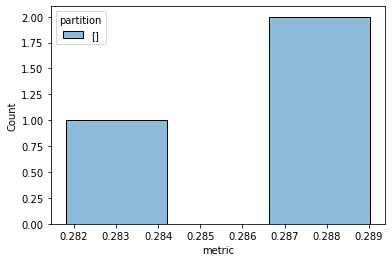

[] 0.28180971125916277 {'trial': {'trial_id': 'fcfcdf23-1a9f-56a2-8638-6a32280d8ed0', 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100}, 'metadata': {}, 'keys': []}, 'metric': 0.28180971125916277, 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.28180971125916277, 'log_time': datetime.datetime(2022, 9, 1, 1, 4, 13, 613623)}


In [19]:
result = suggest_for_noniterative_objective(
    objective,
    xgb_space,
    monitor="hist"
)

This can also be used with Spark or Dask as long as we specify an RPCClient. The RPCClient also comes from Fugue. In the example below, we use `"ts"` to monitor the up-to-date best metric. 

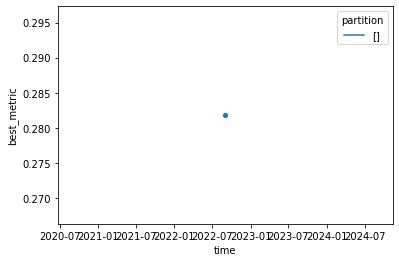

[] 0.28180971125916277 {'trial': {'trial_id': 'fcfcdf23-1a9f-56a2-8638-6a32280d8ed0', 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100}, 'metadata': {}, 'keys': []}, 'metric': 0.28180971125916277, 'params': {'model': <class 'xgboost.sklearn.XGBRegressor'>, 'n_estimators': 100}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.28180971125916277, 'log_time': datetime.datetime(2022, 9, 1, 1, 12, 6, 306297)}


In [27]:
callback_conf = {
    "fugue.rpc.server": "fugue.rpc.flask.FlaskRPCServer",
    "fugue.rpc.flask_server.host": "0.0.0.0",
    "fugue.rpc.flask_server.port": "1234",
    "fugue.rpc.flask_server.timeout": "2 sec",
}

result = suggest_for_noniterative_objective(
    objective,
    xgb_space,
    execution_engine=spark,
    execution_engine_conf=callback_conf,
    monitor="ts"
)

## Logging Tuning Results to Experiment Trackers

It is common to pair Tune with an experiment tracker like [MLFlow](https://mlflow.org/) or [Weights and Biases](https://wandb.ai/site). These platforms will track the previous runs and persist artifacts related to model training. In the example below, we use Weights and Biases and pass a project name. Because this needs an account and API Key to run, we can't run the next cell.

```python
result = suggest_for_noniterative_objective(
    objective,
    xgb_space + lgbm_space,
    local_optimizer = "hyperopt:5",
    execution_engine = client,
    logger = "wandb:CA_housing_tuning"
)
```

## Tuning per Partition

For big data, we may want to split the data into multiple partitions and tune the search space for each individual group. We don't have any good categorical column in the California Housing dataset, so let's change the `HouseAge` column to a categorical. We will change it to `low` and `high`.

In [60]:
data = get_data()
data = data.assign(HouseAge=pd.qcut(data["HouseAge"], q = [0, 0.5, 1], labels=['low','high']))
data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,high,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,low,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,high,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,high,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,high,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We can make this into a Spark DataFrame that will then be partitioned. Training per partition will also work on Pandas DataFrames.

In [61]:
spark_data = spark.createDataFrame(data)

The objective function needs to change a bit because we previously loaded the data inside. Instead, we will pass in the partition as a Pandas DAtaFrame.

In [62]:
def new_objective(data: pd.DataFrame, model:Any, **hp:Any) -> float:
    # data is already partitioned by House Age when it comes in
    model_ins = model(**hp)
    model_age = data.iloc[0]["HouseAge"]
    y = data["MedHouseVal"]
    x = data.drop(["MedHouseVal", "HouseAge"], axis=1)
    scores = cross_val_score(model_ins, x, y, cv=3, 
                             scoring=make_scorer(mean_absolute_percentage_error))
    return scores.mean()

Below is an example of how to put everything together in this section. We use a Spark DataFrame that is partitioned into multiple Pandas DataFrame, and we tune the `Space` for each partition. In order to do this, we need to supply the DataFrame as `df` ahead of time along with the `partition_keys`. The `temp_path` is needed to store temporary files.

In [65]:
result = suggest_for_noniterative_objective(
    new_objective,
    xgb_space + lgbm_space,
    local_optimizer="hyperopt",
    execution_engine=spark,
    df = spark_data,
    df_name = "data",
    temp_path="/tmp/",
    partition_keys=["HouseAge"]
)
result

[{'trial': {'trial_id': '81cd2484-994f-5704-800f-23b791d8d893', 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 124}, 'metadata': {}, 'keys': ['high']}, 'metric': 0.2713623100846554, 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 124}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.2713623100846554, 'log_time': datetime.datetime(2022, 9, 1, 1, 38, 56, 71338)},
 {'trial': {'trial_id': '849f6270-6e81-5ba8-b2c2-ec9ba0718289', 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 127}, 'metadata': {}, 'keys': ['low']}, 'metric': 0.27277650051184715, 'params': {'model': <class 'lightgbm.sklearn.LGBMRegressor'>, 'n_estimators': 127}, 'metadata': {}, 'cost': 1.0, 'rung': 0, 'sort_metric': 0.27277650051184715, 'log_time': datetime.datetime(2022, 9, 1, 1, 39, 10, 137673)}]

## Conclusion

In this section, we went over the features of the `suggest_for_noniterative_objective`. We showed how the `Space` and objective function can be defined without worrying about the underlying optimization framework. When ready to perform tuning, we can bring them together and specify the `local_optimizer` and `execution_engine` to run our jobs on. Because Tune is built on top of Fugue, we can run Hyperopt or Optuna on top of Spark, Dask, and Ray. 

We can also utilize distributed compute to tune the search space for each partition and get the best results. All we had to do was supply `partition_keys` to our Spark DataFrame and we were able to find the best model for each group of data. 

Tune lets users define their tuning problems in a minimal grammar, and then takes care of executing it on top of specifed optimizers and engines.